# intNMF example

example using a 10x dataset with cell type annotations. Firstly download the data.

In [1]:
%%bash
#wget --no-check-certificate --no-verbose -P ../data/  https://costalab.ukaachen.de/open_data/MOJITOO/PBMC-Multiom_annotation.tsv
#wget --no-verbose -P ../data/ https://cf.10xgenomics.com/samples/cell-arc/1.0.0/pbmc_granulocyte_sorted_10k/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5

import required packages for loading the data then load the data

In [2]:
import muon as mu
import anndata as ad
import scanpy as sc
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def load_multiome(file, labels):
    '''Function to load multiome data from .h5, .h5ad or .h5mu file types'''

    _, extension = os.path.splitext(file)
    if extension == '.h5':
        mu_data = mu.read_10x_h5(file)
            
    elif extension == '.h5ad':
        h5ad = ad.read_h5ad(file)
        rna = h5ad[:, h5ad.var['feature_types'] == 'GEX']
        atac = h5ad[:, h5ad.var['feature_types'] == 'ATAC']
        mu_data = mu.MuData({'rna': rna, 'atac': atac})
        mu_data.update()
        mu.pp.intersect_obs(mu_data)
    elif extension == '.h5mu':
        mu_data = mu.read(file)
    
    # If there are labels for the dataset load the labels and remove cells without a label.
    if labels is None:
        print('no labels')
    else:
        meta = pd.read_csv(labels, sep="\t", header=0, index_col=0)
        mu.pp.filter_obs(mu_data, meta.index.values)
        mu_data.obs = meta
        
    return mu_data


In [4]:
file = '../data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5'
labels = '../data/PBMC-Multiom_annotation.tsv'

mu_data = load_multiome(file, labels)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from ../data/pbmc_granulocyte_sorted_10k_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
mu_data

MuData object with n_obs × n_vars = 11787 × 144978
  obs:	'clusters', 'annotation'
  var:	'feature_types', 'gene_ids', 'genome', 'interval'
  2 modalities
    rna:	11787 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11787 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

import intNMF package and then run

In [6]:
import sys

path_to_nmf = '../../nmf_models/'
module_path = os.path.abspath(os.path.join(path_to_nmf))

if module_path not in sys.path:
    sys.path.append(module_path)
from nmf_models_mod_updates import intNMF, log_tf_idf


In [7]:
rna_tf_idf = log_tf_idf(mu_data['rna'].X)
atac_tf_idf = log_tf_idf(mu_data['atac'].X)

In [8]:
atac_tf_idf

<11787x108377 sparse matrix of type '<class 'numpy.float32'>'
	with 84935771 stored elements in Compressed Sparse Column format>

In [9]:
rna_tf_idf

<11787x36601 sparse matrix of type '<class 'numpy.float32'>'
	with 23463054 stored elements in Compressed Sparse Column format>

In [10]:
nmf_model = intNMF(10)  # NMF model with k=10
nmf_model.fit(rna_tf_idf, atac_tf_idf)


In [11]:
nmf_model.phi_atac

array([[3.19645222e-16, 3.19645222e-16, 2.29852442e-02, ...,
        3.19645222e-16, 3.19645222e-16, 3.19645222e-16],
       [1.56909411e-02, 3.26322738e-02, 2.53510286e-02, ...,
        2.59588081e-01, 1.26000510e-01, 3.58362931e-02],
       [2.33920733e-02, 5.33966439e-02, 4.35770132e-02, ...,
        2.91956203e-02, 3.19645222e-16, 7.17555617e-02],
       ...,
       [3.19641753e-16, 3.33831754e-02, 3.19641753e-16, ...,
        8.29680795e-03, 4.53754626e-02, 3.19641753e-16],
       [1.11058238e-02, 2.30085737e-03, 3.19641753e-16, ...,
        4.70762741e-02, 8.30483025e-02, 6.93059868e-01],
       [4.21135612e-02, 8.48015962e-02, 1.64176009e-02, ...,
        1.49505436e-01, 3.71010890e-02, 3.19641753e-16]])

In [12]:
mu_data.obsm['intNMF'] = nmf_model.theta

In [13]:
mu_data['rna'].varm['intNMF'] = nmf_model.phi_rna.T
mu_data['atac'].varm['intNMF'] = nmf_model.phi_atac.T

In [14]:
import plotting as pl
import importlib


In [24]:
importlib.reload(pl)

<module 'plotting' from '/mnt/fls01-home01/j72687wm/nmf_models/nmf_models/plotting.py'>

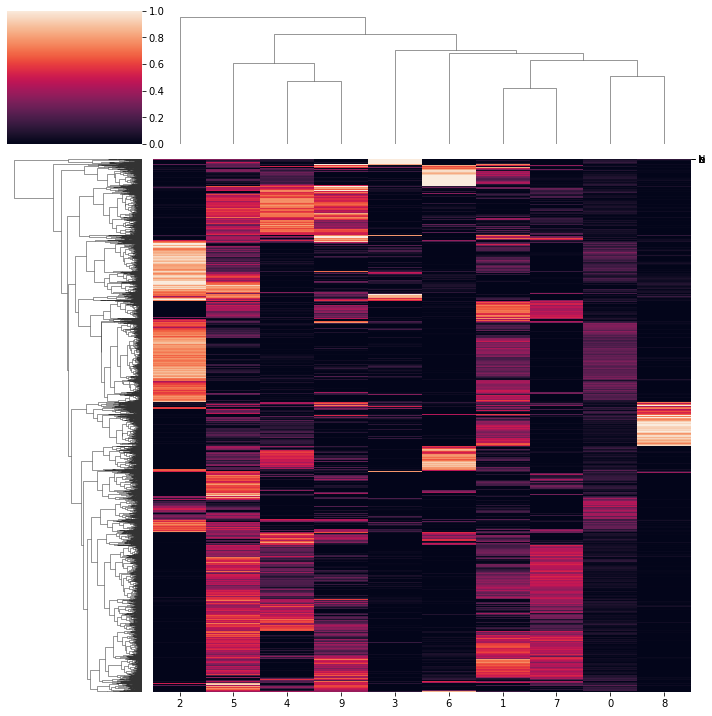

In [25]:
pl.view_embed(nmf_model, clustered=True)

3660.1
10837.7


/mnt/fls01-home01/j72687wm/nmf_models/nmf_models/plotting.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/mnt/fls01-home01/j72687wm/mambaforge/envs/single-cell_python/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


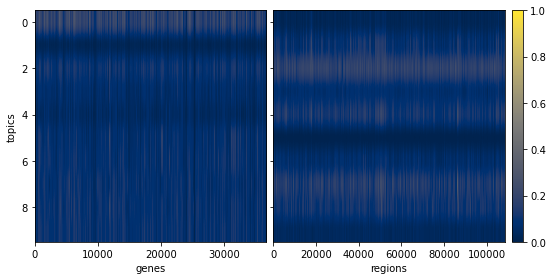

In [28]:
ax = pl.view_loadings(nmf_model, 'both') #can also view a single modality with atac or rna

3660.1


<AxesSubplot:xlabel='genes', ylabel='topics'>

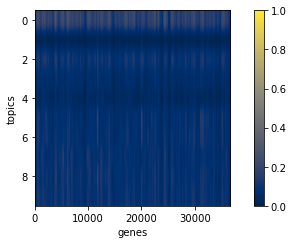

In [27]:
pl.view_loadings(nmf_model, 'rna') #can also view a single modality with atac or rna

<AxesSubplot:>

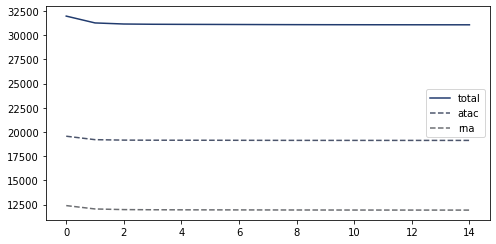

In [29]:
pl.loss(nmf_model)

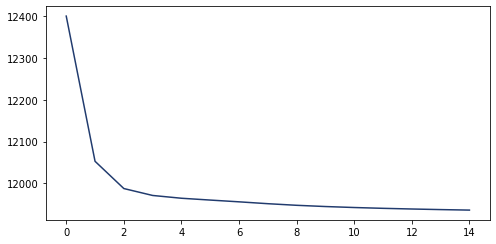

In [31]:
ax = pl.loss(nmf_model, 'rna')

In [32]:
corr_mat = np.corrcoef(nmf_model.theta.T)

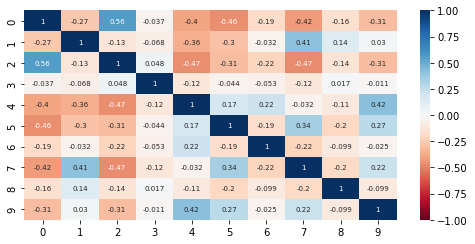

In [33]:
pl.correlation_plot(corr_mat)

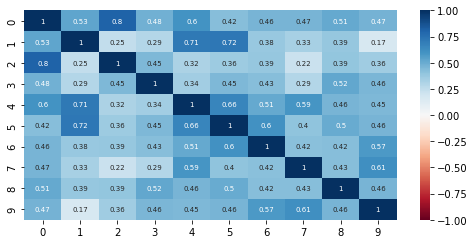

In [34]:
corr_mat = np.corrcoef(nmf_model.phi_rna)
pl.correlation_plot(corr_mat)

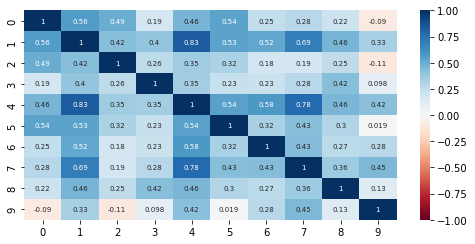

In [35]:
corr_mat = np.corrcoef(nmf_model.phi_atac)
pl.correlation_plot(corr_mat)

In [36]:
corr_mat.shape

(10, 10)

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [60.0, 60.0, 82.5, 82.5],
  [32.5, 32.5, 71.25, 71.25],
  [10.0, 10.0, 51.875, 51.875]],
 'dcoord': [[0.0, 0.39, 0.39, 0.0],
  [0.0, 0.278, 0.278, 0.0],
  [0.0, 0.33699999999999997, 0.33699999999999997, 0.278],
  [0.0, 0.19499999999999995, 0.19499999999999995, 0.0],
  [0.0, 0.48, 0.48, 0.0],
  [0.0, 0.575, 0.575, 0.48],
  [0.19499999999999995, 0.612, 0.612, 0.575],
  [0.33699999999999997, 0.75, 0.75, 0.612],
  [0.39, 0.831, 0.831, 0.75]],
 'ivl': ['7', '9', '4', '1', '5', '0', '2', '6', '3', '8'],
 'leaves': [7, 9, 4, 1, 5, 0, 2, 6, 3, 8],
 'color_list': ['C1', 'C2', 'C2', 'C3', 'C4', 'C4', 'C0', 'C0', 'C0'],
 'leaves_color_list': ['C1',
  'C1',
  'C2',
  'C2',
  'C2',
  'C3',
  'C3',
  'C4',
  'C4',
  'C4']}

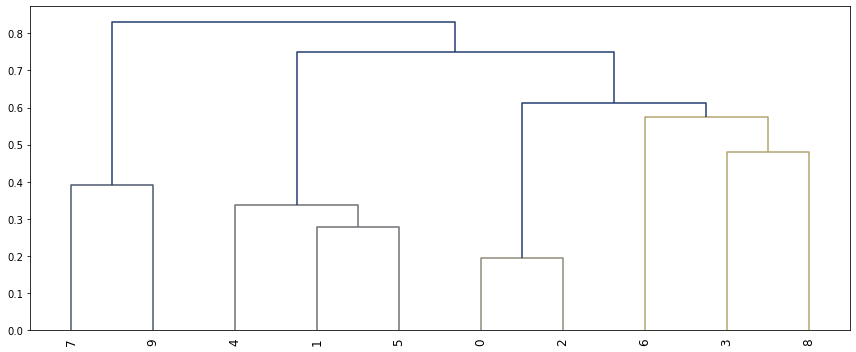

In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import seaborn as sns

plt.figure(figsize=(12,5))
corr_mat = np.round(np.corrcoef(nmf_model.phi_rna), 3)
dissimilarity = 1 - abs(corr_mat)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, orientation='top', 
           leaf_rotation=90)

In [ ]:
# Clusterize the data
threshold = 0.8
labels = fcluster(Z, 0.5, criterion='distance')

# Show the cluster
labels

In [ ]:
corr_mat = np.round(np.corrcoef(nmf_model.phi_rna), 3)
sns.clustermap(corr_mat, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1)

In [ ]:
corr_mat = np.round(np.corrcoef(nmf_model.phi_atac), 3)
sns.clustermap(corr_mat, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1)

In [ ]:
corr_mat = np.round(np.corrcoef(nmf_model.theta.T), 3)
sns.clustermap(corr_mat, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1)

In [ ]:
# Clusterize the data
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

In [ ]:
sns.clustermap(corr_mat, method="complete", annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

In [ ]:
sns.set_palette(plt.cm.cividis(np.linspace(0, 1, 8))[1:-1])
